In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


#######################Тут не все компании!!!######################################
#######################Тут не все компании!!!######################################
companies = ['SBER','GAZP' , 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'AFLT', 'AFKS',
       'TRNFP', 'CBOM',
       'FIVE', 'MOEX',
       'HYDR']
companies = ['SBER','SBERP','VTBR','MOEX']
######################Тут не все компании!!!##############################################
######################Тут не все компании!!!##############################################

/tmp/ipykernel_40012/3690817267.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [3]:
l = []
for i in companies:
    data = total_df[total_df['secid'] == i]
    l.append(data.shape[0])

max_len = min(l)
data = np.zeros((max_len, len(companies)))
for i, company in enumerate(companies):
    series = np.array(total_df[total_df.secid == company].close)[:max_len]
    data[:,i] += series


In [5]:
# train_data = data[ : round(data.shape[0]*0.55) ]
# val_data = data[ round(data.shape[0]*0.85) : ]


train_data = data[ : round(data.shape[0]*0.80) ]
val_data = data[ round(data.shape[0]*0.80) : ]

In [6]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [7]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [8]:
def to_sequences(seq_size, obs, dec_seq_size):
    '''
    Цена должна быть в 0 столбце!!!
    '''
    enc_in = []
    dec_in = []
    y = []
    
    for i in range(len(obs) - seq_size):
        enc_part = obs[i:(i + seq_size),:]
        dec_part = obs[i+seq_size-(dec_seq_size) : i+seq_size, : ]
        y_part = obs[i + seq_size,0]
        
        enc_in.append(enc_part)
        dec_in.append(dec_part)
        y.append(y_part)
        
    enc_in = torch.Tensor(np.array(enc_in))
    dec_in = torch.Tensor(np.array(dec_in))
    y = torch.Tensor(np.array(y))
    return enc_in, dec_in, y

In [9]:
SEQUENCE_SIZE = 32
dec_seq_size = 1

x_enc_train1, x_dec_train1, y_train1 = to_sequences(SEQUENCE_SIZE, train_data1, dec_seq_size)
x_enc_train2, x_dec_train2, y_train2 = to_sequences(SEQUENCE_SIZE, train_data2, dec_seq_size)
x_enc_val, x_dec_val, y_val = to_sequences(SEQUENCE_SIZE, val_data, dec_seq_size)


x_enc_train= torch.Tensor( np.concatenate([x_enc_train1, x_enc_train2]) )
x_dec_train= torch.Tensor( np.concatenate([x_dec_train1, x_dec_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )



train_dataset = TensorDataset(x_enc_train, x_dec_train, y_train)
val_dataset  = TensorDataset(x_enc_val, x_dec_val, y_val)                           

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

for x_enc_train, x_dec_train, y_ in train_loader:
    print(x_enc_train.shape)
    print(x_dec_train.shape)
    print(y_.shape)
    break

torch.Size([150, 32, 4])
torch.Size([150, 1, 4])
torch.Size([150])


In [12]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=4, d_model=512, nhead=8, num_layers=4, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder1 = nn.Linear(input_dim, d_model)
        self.ebedder2 = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        decoder_layers = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        enc = self.ebedder1(x[0])
        enc = self.pos_encoder(enc)
        enc = self.transformer_encoder(enc)
        dec = self.ebedder2( x[1] )
        out = self.transformer_decoder(dec, enc)[:,-1]
        out = self.head(out)
        return out

In [11]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/(512,8,4,0.1)TRANS(ENC+DEC)(M F=AS)1D|||W=0.4608, VL=2.3302'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [23]:
model = TransformerModel( input_dim=len(companies), d_model=512, nhead=8, num_layers=3, dropout=0.0).to(device)

In [24]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model( (x_enc, x_dec) )
        loss = criterion(outputs.view(-1,), y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_enc, x_dec, y_batch = batch
            x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
            outputs = model( (x_enc, x_dec) )
            loss = criterion(outputs.view(-1,), y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.00012:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для CUSTOM_TRANS val_loss = {val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 25:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.8f} Validation Loss: {val_loss:.8f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 1.26943444 Validation Loss: 0.26973689


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.04119294 Validation Loss: 0.18211762


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.02456154 Validation Loss: 0.10023814


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.02083977 Validation Loss: 0.05027432


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.01554119 Validation Loss: 0.04197963


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.01354830 Validation Loss: 0.01456817


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.01334302 Validation Loss: 0.01084181


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.01295056 Validation Loss: 0.00713857


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.00966198 Validation Loss: 0.00630847


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.00743068 Validation Loss: 0.00494621


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.00777511 Validation Loss: 0.00497997


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.00665552 Validation Loss: 0.00601825


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.00608004 Validation Loss: 0.00382225


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.00598202 Validation Loss: 0.01634338


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.00781734 Validation Loss: 0.00544039


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.00630782 Validation Loss: 0.00957988


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.5000e-04.
Epoch 17 / 50,Train Loss: 0.00530840 Validation Loss: 0.00532031


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.00452416 Validation Loss: 0.00515612


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.00457802 Validation Loss: 0.00777381


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.00508442 Validation Loss: 0.00739726


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 7.5000e-05.
Epoch 21 / 50,Train Loss: 0.00413456 Validation Loss: 0.00542039


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.00429200 Validation Loss: 0.00420148


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.00396198 Validation Loss: 0.00468915


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.00377894 Validation Loss: 0.00398573


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 3.7500e-05.
Epoch 25 / 50,Train Loss: 0.00362381 Validation Loss: 0.00421587


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.00350971 Validation Loss: 0.00378557


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.00363516 Validation Loss: 0.00433704


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.00358272 Validation Loss: 0.00437752


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.00353062 Validation Loss: 0.00544603


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.8750e-05.
Epoch 30 / 50,Train Loss: 0.00337889 Validation Loss: 0.00447801


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.00337047 Validation Loss: 0.00401898


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.00329160 Validation Loss: 0.00389588


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.00349685 Validation Loss: 0.00488777


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 9.3750e-06.
Epoch 34 / 50,Train Loss: 0.00353754 Validation Loss: 0.00453192


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.00331639 Validation Loss: 0.00411111


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.00345293 Validation Loss: 0.00455665


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.00334004 Validation Loss: 0.00413774


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 4.6875e-06.
Epoch 38 / 50,Train Loss: 0.00338406 Validation Loss: 0.00471035


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.00335501 Validation Loss: 0.00402437


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.00317910 Validation Loss: 0.00433095


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.00330298 Validation Loss: 0.00418218


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.3437e-06.
Epoch 42 / 50,Train Loss: 0.00334712 Validation Loss: 0.00431849


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 0.00333591 Validation Loss: 0.00410498


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 0.00330003 Validation Loss: 0.00439461


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45 / 50,Train Loss: 0.00332809 Validation Loss: 0.00433386


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 1.1719e-06.
Epoch 46 / 50,Train Loss: 0.00321687 Validation Loss: 0.00433589


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 50,Train Loss: 0.00328582 Validation Loss: 0.00422999


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 50,Train Loss: 0.00319188 Validation Loss: 0.00427375


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49 / 50,Train Loss: 0.00335992 Validation Loss: 0.00430388


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00050: reducing learning rate of group 0 to 5.8594e-07.
Epoch 50 / 50,Train Loss: 0.00335802 Validation Loss: 0.00427790
Training complete in 3m 9s


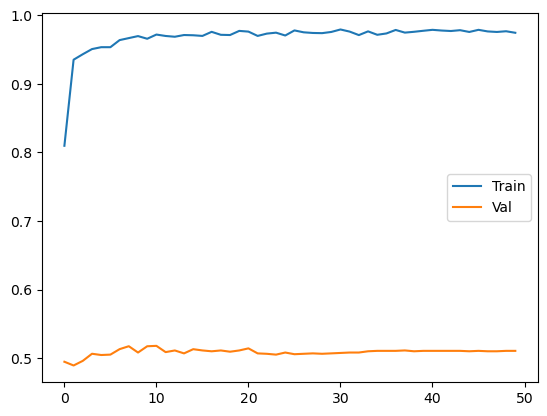

In [25]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

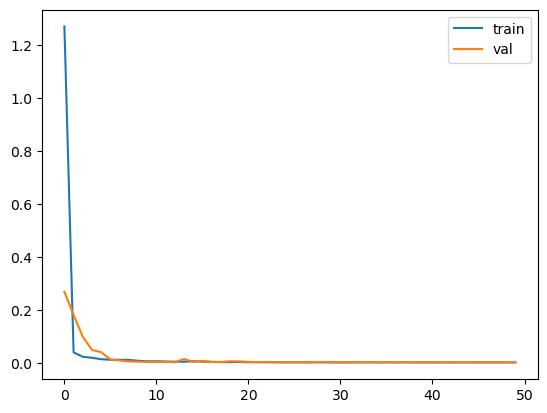

In [26]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['train','val'])

In [30]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [31]:
winrate(y_val.numpy(), predictions1)

0.5125887669464171

In [32]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [33]:
y_val = scaler_star.inverse_transform(y_val.reshape(-1,1))

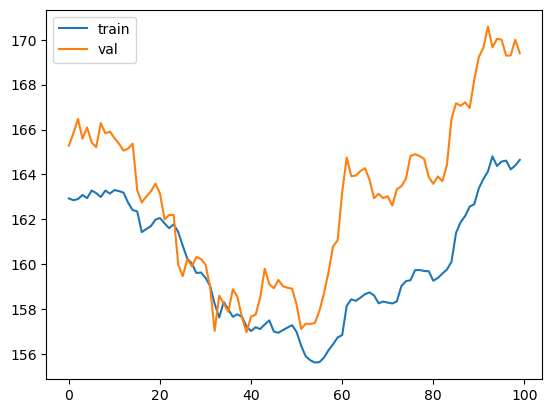

In [41]:
plt.plot(predictions1[:100])
plt.plot(y_val[:100])
plt.legend(['train','val'])

In [34]:
criterion(torch.Tensor(y_val),torch.Tensor(predictions1)).item()

24.833969116210938

In [35]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_enc, x_dec, y_batch = batch
        x_enc, x_dec, y_batch = x_enc.to(device), x_dec.to(device), y_batch.to(device)
        outputs = model( (x_enc, x_dec) )
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [36]:
winrate(y_train.reshape(-1,), predictions2.reshape(-1,))

0.48922753547031006

In [37]:
y_train = scaler_star.inverse_transform(y_train.reshape(-1,1))

In [38]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [39]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(20.8406)

In [42]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,8,3,0.0]TRANS(ENC+DEC) (M F=AS) 1D|W=0.5125, TL=20.8406 VL=24.8339' )